# Some settings and configurations

In [43]:
label_code = {
    'AD': 2,
    'MCI': 1,
    'NC': 0
}

caffe_folder = '/home/xubiker/dev/caffe_modified/'

# Load caffe

It is needed to work with lmdb.

In [44]:
def load_caffe(caffe_root):
    import sys
    pcr = caffe_root + "/python"
    if not pcr in sys.path:
        sys.path.append(pcr)

In [45]:
load_caffe(caffe_folder)
import caffe
print('caffe', caffe.__version__, 'loaded')

caffe 1.0.0-rc3 loaded


# Transform .nii to np-array

In [46]:
def nii_to_array(nii_filename, data_type, fix_nan=True):
    import os
    import nibabel as nib
    import numpy as np
    img = nib.load(nii_filename)
    np_data = img.get_data().astype(data_type)
    if fix_nan:
        np_data = np.nan_to_num(np_data)
    return np_data

# Functions to save data to LMDB

In [47]:
def initiate_lmdb(lmdb_name, drop_existing = False):
    import lmdb
    import caffe
    import numpy as np
    
    if drop_existing:
        import os
        import shutil
        if os.path.exists(lmdb_name):
            shutil.rmtree(lmdb_name) 
    
    env = lmdb.open(lmdb_name, map_size=int(1e12))
    print('database debug info:', env.stat())
    return env

In [48]:
def write_to_transaction(txn, data, label, key):
    import caffe
    datum = caffe.proto.caffe_pb2.Datum()
    (datum.width, datum.height, datum.channels) = data.shape
    datum.data = data.tobytes()
    datum.label = label
    key = '{:08}'.format(key)
    txn.put(key.encode('ascii'), datum.SerializeToString())

In [49]:
def array_to_proto(data, proto_name):
    import caffe
    blob = caffe.io.array_to_blobproto(data)
    binaryproto_file = open(proto_name, 'wb+')
    binaryproto_file.write(blob.SerializeToString())
    binaryproto_file.close()

# Functions to validate LMDB

In [50]:
def debug_lmdb_print_info(lmdb_name):
    import caffe
    print('debug printing for \'', lmdb_name, '\' lmdb data')
    env = initiate_lmdb(lmdb_name, drop_existing = False)
    print(env.stat())
    with env.begin() as txn:
        cursor = txn.cursor()
        datum = caffe.proto.caffe_pb2.Datum()
        i = 0
        for key, value in cursor:
            i += 1
            datum.ParseFromString(value)
            print('inst %d of size (%d, %d, %d) labeled %d' % (i, datum.width, datum.height, datum.channels, datum.label))

In [51]:
def debug_plot_median_slices(np_data, print_slices=False):
    import matplotlib.pyplot as plt
    x, y, z = np_data.shape
    slc = np_data[:, :, z//2]
    if print_slices: print(slc)
    plt.matshow(slc, interpolation='nearest', cmap='gray')
    plt.show()
    slc = np_data[:, y//2, :]
    if print_slices: print(slc)
    plt.matshow(slc, interpolation='nearest', cmap='gray')
    plt.show()
    slc = np_data[x//2, :, :]
    if print_slices: print(slc)
    plt.matshow(slc, interpolation='nearest', cmap='gray')
    plt.show()

In [52]:
def debug_lmdb_plot_slices(lmdb_name, data_type, print_slices=False):
    import numpy as np
    #np.set_printoptions(threshold=np.inf)
    import caffe
    import matplotlib.pyplot as plt
    from random import randint
    print('debug plotting slices for \'%s\' lmdb data' % lmdb_name)
    env = initiate_lmdb(lmdb_name, drop_existing = False)
    with env.begin() as txn:
        cursor = txn.cursor()
        datum = caffe.proto.caffe_pb2.Datum()
        cursor.next();
        value = cursor.value();
        datum.ParseFromString(value)
        flat_x = np.fromstring(datum.data, dtype=data_type)
        x = flat_x.reshape(datum.width, datum.height, datum.channels)
        debug_plot_median_slices(x, print_slices)

# Functions to generate data lists

In [53]:
def generate_augm_params(max_augm_params):
    import numpy as np
    import random
    random.seed()
    max_shift = max_augm_params['shift']
    max_blur = max_augm_params['blur']
    while True:
        shift_x = random.randint(-max_shift, max_shift)
        shift_y = random.randint(-max_shift, max_shift)
        shift_z = random.randint(-max_shift, max_shift)
        blur_sigma = random.random() * max_blur
        if shift_x + shift_y + shift_z + blur_sigma > 0:
            return (shift_x, shift_y, shift_z, blur_sigma)

In [54]:
def generate_augm_lists(dirs_with_labels, new_size, max_augm_params, default_augm_params=None):
    import random
    import math
    if new_size == None or len(dirs_with_labels) == new_size:
        return [dwl + [default_augm_params] for dwl in dirs_with_labels]
    augm_coeff = int(math.floor(new_size / len(dirs_with_labels)))
    res = []
    i = 0
    for dwl in dirs_with_labels:
        res.append(dwl + [(0, 0, 0, 0.0)])
        i += 1
        for _ in range(augm_coeff-1):
            res.append(dwl + [generate_augm_params(max_augm_params)])
            i += 1
    while i < new_size:
        dwl = random.choice(dirs_with_labels)
        res.append(dwl +[generate_augm_params(max_augm_params)])
        i += 1
    return res

In [55]:
def generate_lists_from_adni2(adni_root, max_augm_params, augm_factor, valid_prc = 0.25, test_prc = 0.25, shuffle_data=True, debug=True):
    
    import os
    import numpy as np
    import random

    stage_dirs = {
        'AD': adni_root + '/AD/',
        'MCI': adni_root + '/MCI/',
        'NC': adni_root + '/NC/'
    }
    
    default_augm = (0, 0, 0, 0.0)
    
    patients_MRI_train = []
    patients_MD_train = []
    patients_MRI_test = []
    patients_MD_test = []
    
    
    class_size = {k: len(os.listdir(stage_dirs[k])) for k in stage_dirs}
    print('source patients:', class_size)

    ts = int(min(class_size.values()) * test_prc)
    test_size = {k: ts for k in stage_dirs}
    valid_size = {k: int(class_size[k] * valid_prc) for k in stage_dirs}
    train_size = {k: class_size[k] - test_size[k] - valid_size[k] for k in stage_dirs}
    
    print('source patients used for train:', train_size)
    print('source patients used for validation:', valid_size)
    print('source patients used for test', test_size)

    train_size_balanced = int(max(train_size.values()) * augm_factor)
    valid_size_balanced = int(max(valid_size.values()) * augm_factor)
    print('train data will be augmented to %d samples by each class' % train_size_balanced)
    print('validation data will be augmented to %d samples by each class' % valid_size_balanced)
    print('test data will be augmented to %d samples by each class' % ts)
    
    train_lists_out = []
    valid_lists_out = []
    test_lists_out = []
    
    for k in stage_dirs:
        stage_dir = stage_dirs[k]
        patient_dirs = os.listdir(stage_dirs[k])
        np.random.shuffle(patient_dirs)

        test_dirs = patient_dirs[:test_size[k]]
        valid_dirs = patient_dirs[test_size[k]:test_size[k]+valid_size[k]]
        train_dirs = patient_dirs[test_size[k]+valid_size[k]:]
                                 
        train_lists = [[k, stage_dir + d + '/SMRI/', stage_dir + d + '/MD/'] for d in train_dirs]
        valid_lists = [[k, stage_dir + d + '/SMRI/', stage_dir + d + '/MD/'] for d in valid_dirs]
        test_lists = [[k, stage_dir + d + '/SMRI/', stage_dir + d + '/MD/'] for d in test_dirs]
        
        train_lists_out += generate_augm_lists(train_lists, train_size_balanced, max_augm_params)
        valid_lists_out += generate_augm_lists(valid_lists, valid_size_balanced, max_augm_params)
        test_lists_out += generate_augm_lists(test_lists, None, None, default_augm_params=default_augm)
    
    if shuffle_data:
        random.shuffle(train_lists_out)
        random.shuffle(valid_lists_out)
        random.shuffle(test_lists_out)
    
    if debug:
        print('### train lists (%d instances):' % len(train_lists_out))
        for i in train_lists_out: print(i)
        print('### valid lists (%d instances):' % len(valid_lists_out))
        for i in valid_lists_out: print(i)
        print('### test lists (%d instances):' % len(test_lists_out))
        for i in test_lists_out: print(i)
        
        
    return (train_lists_out, valid_lists_out, test_lists_out)

In [56]:
def split_mri_dti(item_list):
    mri_list = [(i[0], i[1], i[3]) for i in item_list]
    dti_list = [(i[0], i[2], i[3]) for i in item_list]
    return mri_list, dti_list

In [57]:
def get_nii_from_folder(folder):
    import os
    res = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.nii'):
                res.append(os.path.join(root, file))
    if len(res) > 1:
        print('WARNING. Folder %s contains more than one files' % folder)
    return res

# Functions to preprocess and augment data

In [58]:
def crop(data, crop_prc, shift_prc):
    dims = np.array(data.shape).astype(np.float)
    pads = np.round(dims * np.array(crop_prc).astype(np.float)).astype(np.int)
    shifts = np.round(dims * np.array(shift_prc).astype(np.float)).astype(np.int)
    if pads.size != 3:
        raise NameError('unsupported number of dimensions')
    else:
        x, y, z = data.shape
        pad_x, pad_y, pad_z = pads
        sh_x, sh_y, sh_z = shifts
        data_new = data[sh_x+pad_x:x+sh_x-pad_x, sh_y+pad_y:y+sh_y-pad_y, sh_z+pad_z:z+sh_z-pad_z]
        print('cropping data:', data.shape, '->', data_new.shape)
        return data_new    

In [59]:
def augment(data, max_shift, augm_params):

    # augm_params should be a tuple of 4 elements: shift_x, shift_y, shift_z, blur_sigma
    if data.ndim != 3 or len(augm_params) != 4: raise NameError('invalid input')
    
    import numpy as np
    from random import randint
    from scipy.ndimage.filters import gaussian_filter
    
    shift_x = augm_params[0]
    shift_y = augm_params[1]
    shift_z = augm_params[2]
    blur_sigma = augm_params[3]
    
    s_x, s_y, s_z = (data.shape[0] - 2 * max_shift, data.shape[1] - 2 * max_shift, data.shape[2] - 2 * max_shift)

    blurred = data if blur_sigma == 0 else gaussian_filter(data, sigma = blur_sigma)
    sub_data = blurred[max_shift + shift_x : s_x + max_shift + shift_x,
                       max_shift + shift_y : s_y + max_shift + shift_y,
                       max_shift + shift_z : s_z + max_shift + shift_z]
    return sub_data

In [60]:
def process(list_item, data_type, max_augm_shift, crop_params=None):
    nii = get_nii_from_folder(list_item[1])[0]
    array = nii_to_array(nii, data_type)
    if crop_params != None:
        array = crop(array, crop_prc=crop_params['prc'], shift_prc=crop_params['shift'])
    augm = augment(array, max_augm_shift, list_item[2])
    return augm

In [61]:
def make_lmdb(one_modality_list, data_type, lmdb_name, max_augm_shift, crop_params=None):
    env = initiate_lmdb(lmdb_name, drop_existing = True)
    key = 0
    with env.begin(write=True) as txn:
        for i in one_modality_list:
            augm = process(i, data_type, max_augm_shift, crop_params)
            print('%d. writing image of shape %s to lmdb (%s)' % (key, str(augm.shape), i[1]))
            write_to_transaction(txn, augm, label_code[i[0]], key)
            key += 1

# Functions to generate mean file

In [62]:
def calc_lmdb_mean(lmdb_path, data_type, reshape_4D = True, plot_mean = True):
    import caffe
    import numpy as np
    import matplotlib.pyplot as plt
    
    env = initiate_lmdb(lmdb_path, drop_existing = False)
    mean = np.empty
    i = 0
    with env.begin() as txn:
        datum = caffe.proto.caffe_pb2.Datum()
        cursor = txn.cursor()
        cursor.next();
        datum.ParseFromString(cursor.value())
        mean = np.zeros([datum.channels, datum.height, datum.width])
        cursor = txn.cursor()
        for key, value in cursor:
            i += 1
            datum.ParseFromString(value)
            flat = np.fromstring(datum.data, dtype=data_type)
            x = flat.reshape(datum.channels, datum.height, datum.width)
            mean = np.add(mean, x)
    mean = np.divide(mean, i)
    if plot_mean:
        debug_plot_median_slices(mean)
    if reshape_4D:
        mean = mean.reshape((1,) + mean.shape)
        print('mean image reshaped to', mean.shape)
    return mean

# An example of how to do data preprocessing

source patients: {'NC': 58, 'AD': 48, 'MCI': 108}
source patients used for train: {'NC': 32, 'AD': 24, 'MCI': 69}
source patients used for validation: {'NC': 14, 'AD': 12, 'MCI': 27}
source patients used for test {'NC': 12, 'AD': 12, 'MCI': 12}
train data will be augmented to 138 samples by each class
validation data will be augmented to 54 samples by each class
test data will be augmented to 12 samples by each class
database debug info: {'overflow_pages': 0, 'entries': 0, 'branch_pages': 0, 'depth': 0, 'psize': 4096, 'leaf_pages': 0}
cropping data: (121, 145, 121) -> (109, 131, 109)
0. writing image of shape (105, 127, 105) to lmdb (/home/xubiker/ADNI_Multimodal/dataset//NC/003_S_4288/SMRI/)
cropping data: (121, 145, 121) -> (109, 131, 109)
1. writing image of shape (105, 127, 105) to lmdb (/home/xubiker/ADNI_Multimodal/dataset//MCI/126_S_4507/SMRI/)
cropping data: (121, 145, 121) -> (109, 131, 109)
2. writing image of shape (105, 127, 105) to lmdb (/home/xubiker/ADNI_Multimodal/datas

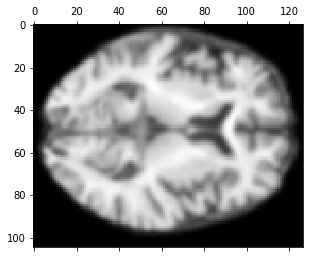

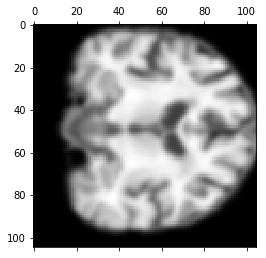

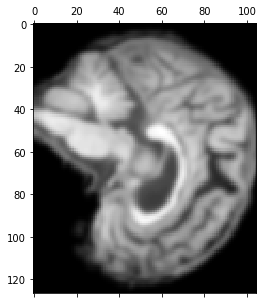

database debug info: {'overflow_pages': 443070, 'entries': 162, 'branch_pages': 1, 'depth': 2, 'psize': 4096, 'leaf_pages': 2}


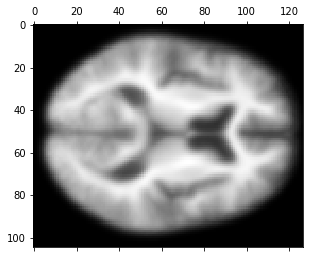

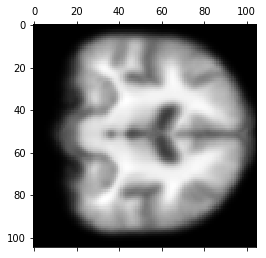

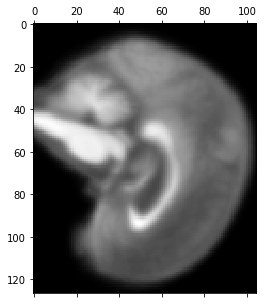

mean image reshaped to (1, 105, 127, 105)


In [63]:
import numpy as np
adni_root = '/home/xubiker/ADNI_Multimodal/dataset/'
max_augm = {'shift': 2, 'blur': 1.2}
test_prc = 0.25
valid_prc = 0.25
augm_factor = 2
dtype = np.float

crop_params = {'shift': (0, 0, -0.05), 'prc': (0.05, 0.05, 0.05)}


train_list, valid_list, test_list = generate_lists_from_adni2(
    adni_root, max_augm, test_prc=test_prc, valid_prc=valid_prc, augm_factor=augm_factor,
    shuffle_data=True, debug=False)

train_mri_list, train_dti_list = split_mri_dti(train_list)
valid_mri_list, valid_dti_list = split_mri_dti(valid_list)
test_mri_list, test_dti_list = split_mri_dti(test_list)

# lists_with_names = zip(
#     [train_mri_list, valid_mri_list, test_mri_list, train_dti_list, valid_dti_list, test_dti_list],
#     ['alz_sMRI_train', 'alz_sMRI_valid', 'alz_sMRI_test', 'alz_MD_train', 'alz_MD_valid', 'alz_MD_test'])
lists_with_names = zip(
    [valid_mri_list],
    ['alz_MRI_valid'])

for i in lists_with_names:
    item = i[0]
    name = i[1]
    make_lmdb(one_modality_list=item, data_type=dtype, lmdb_name=name, max_augm_shift=max_augm['shift'], crop_params=crop_params)
#     debug_lmdb_print_info(name)
    debug_lmdb_plot_slices(name, data_type=dtype)
    mean = calc_lmdb_mean(lmdb_path=name, data_type=dtype, reshape_4D=True, plot_mean=True)
    array_to_proto(data=mean, proto_name=name+'_mean.binaryproto')